# III. Multi view/ stereo view geometry

In [181]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

from lib import projectpoints, box3d

## Epipolar geometry

In [50]:
# Internal parameters of the two cameras
K = np.array([
    [1000, 0   , 300],
    [0   , 1000, 200],
    [0   , 0   , 1  ],
])

# External parameters
R1 = np.eye(3)
t1 = np.zeros((3, 1))

R2 = Rotation.from_euler('xyz', [0.7, -0.5, 0.8]).as_matrix()
t2 = np.array([[0.2, 2, 1]]).T

### 1. Projection of 3D points on the cameras

In [254]:
Q = np.array([[1, 0.5, 4, 1]]).T

q1 = projectpoints(K, R1, t1, Q)[:, 0]
q2 = projectpoints(K, R2, t2, Q)[:, 0]

### 2. Cross product matrix

In [255]:
def CrossOp(p):
    """Return the cross product operator.
    
    Take a vector in 3D and return the 3×3 matrix corresponding
    to taking the cross product with that vector.
    
    Parameter
    ---------
    p: 3 x 1 numpy array
    
    Return
    ------
    CrossOP: 3 x 3 numpy array
        cross product operator.
    
    """
    x, y, z = p.reshape(3)
    return np.array([
        [ 0, - z,  y],
        [ z,   0, -x],
        [-y,   x,  0],
    ])

In [54]:
np.cross(q1.T, q2.T) == CrossOp(q1) @ q2

array([ True,  True,  True])

### 3. Fundamental matrix of the two cameras

In [71]:
def essential_matrix(R, t):
    """Return the essential matrix
    
    Parameters
    ----------
    R: 3 x 3 numpy array
        Rotation matrix of camera 2 in the referential of camera 1
    t: 3 x 1 numpy array
        Translation matrix of camera 2 in the referential of camera 1
    
    Return:
    E: 3 x 3 numpy array
        Essential matrix
    """
    return CrossOp(t) @ R


def fundamental_matrix(K1, K2, R2, t2, R1=np.eye(3), t1=np.zeros(3)):
    """Return the fundamental matrix.
    
    If R1 and t1 are not specified, we assume that we are in the
    coordinate system of camera 1.
    
    Parameters
    ----------
    K1, K2: 3 x 3 numpy array
        intrinsics parameters of the cameras
    R2: 3 x 3 numpy array
        Rotation matrix of camera 2.
    t2: 3 x 1 numpy array
        Translation matrix of camera 2.
    R1: 3 x 3 numpy array, optional. Default: identity matrix
        Rotation matrix of camera 1.
    t2: 3 x 1 numpy array, optional. Default: null vector
        Translation matrix of camera 1.
    
    Return:
    F: 3 x 3 numpy array
        Fundamental matrix
    """
    R = R2 @ R1.T
    t = t2.reshape(3, 1) - R2 @ R1.T @ t1.reshape(3, 1)

    E = essential_matrix(R, t)
    return np.linalg.inv(K2).T @ E @ np.linalg.inv(K1)

In [72]:
F = fundamental_matrix(K, K, R2, t2,)
F

array([[ 3.29311881e-07,  8.19396327e-07,  1.79162592e-03],
       [ 5.15532551e-07, -8.76915984e-07,  9.31426656e-05],
       [-1.29882755e-03,  1.51951700e-03, -1.10072682e+00]])

### 4, 5. Epipolar line

By property of the fundamental matrix:

$q_1 F q_2^T = 0 \Rightarrow l_1 = Fq_2^T$

In [84]:
def epipolar_line(F, q, i=1):
    """
    Epipolar line in camera i.

    Parameters
    ----------
    F: 3 x 3 numpy array
        fundamental matrix.
    q: 3 x 1 numpy array
        homogeneous point in camera i.
    i: int, optional. default: 1
        number of camera, 1 or 2.
    """
    if i == 1:
        return F @ q.reshape(3, 1)
    else:
        return q.reshape(1, 3) @ F

$q_2$ has to be on the epipolar line as $q_2^T F q_1 = 0$

In [99]:
epipolar_line_2 = F @ q1

In [102]:
epipolar_line_2

array([-1.33545418e-07,  3.23315722e-05, -1.04344562e-02])

In [104]:
q2.reshape(1, 3) @ epipolar_line_2

array([-0.0044989])

### 6. Relation between the 3D points in world space and in the frame of camera 1
We know that  $\tilde{\mathit{Q}} = \begin{bmatrix}
        \textbf{R}_1 & \textbf{t}_1\\ 0 & 1
    \end{bmatrix} \mathit{Q}$
    
Therefore:
\begin{align*}
    \begin{bmatrix}
        \textbf{R}_1^T & -\textbf{R}_1^T\textbf{t}_1\\ 0 & 1
    \end{bmatrix} \tilde{\mathit{Q}} 
    &=
    \begin{bmatrix}
        \textbf{R}_1^T & -\textbf{R}_1^T\textbf{t}_1\\ 0 & 1
    \end{bmatrix}
    \begin{bmatrix}
        \textbf{R}_1 & \textbf{t}_1\\ 0 & 1
    \end{bmatrix} \mathit{Q}\\
    &= \begin{bmatrix}
        \textbf{I}_3 & \textbf{0}\\ 0 & 1
    \end{bmatrix} \mathit{Q}\\
    &= \mathit{Q}
\end{align*}

### 7. Coordinate systems

In the following, we will work in the coordinate system of camera one. For this purpose, we use the following expressions for $\textbf{q}_1$ and $\textbf{q}_2$:

\begin{align*}
    \textbf{q}_1 &= \textbf{K}[\textbf{R}_1|\textbf{t}_1]\mathit{Q}\\
    &= \textbf{K}\begin{bmatrix}
            \textbf{I} & 0
       \end{bmatrix} \begin{bmatrix}
            \textbf{R}_1 & \textbf{t}_1\\ \textbf{0} & 1
       \end{bmatrix} \mathit{Q}\\
    &= \textbf{K}\begin{bmatrix}
            \textbf{I} & 0
       \end{bmatrix}  \tilde{\mathit{Q}}
\end{align*}

\begin{align*}
    \textbf{q}_2 &= \textbf{K}[\textbf{R}_2|\textbf{t}_2]\mathit{Q}\\
    &= \textbf{K}[\textbf{R}_2|\textbf{t}_2]\begin{bmatrix}
        \textbf{R}_1^T & -\textbf{R}_1^T\textbf{t}_1\\ 0 & 1
    \end{bmatrix} \tilde{\mathit{Q}}\\
    &=  \textbf{K}\begin{bmatrix} 
            \textbf{R}_2\textbf{R}_1^T & \textbf{t}_2 - \tilde {\textbf{R}}_2\textbf{t}_1
        \end{bmatrix}
    \tilde{\mathit{Q}}\\
    &=  \textbf{K}\begin{bmatrix} 
            \tilde{\textbf{R}}_2 & \tilde{\textbf{t}}_2
        \end{bmatrix}
    \tilde{\mathit{Q}}\\
\end{align*}

## Applied epipolar geometry

### 8. Fundamental matrix on real data

R1: 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 

t1: 
[[0.]
 [0.]
 [0.]] 

R2: 
[[ 9.971e-01  1.000e-04  7.660e-02]
 [-1.000e-04  1.000e+00  2.000e-04]
 [-7.660e-02 -2.000e-04  9.971e-01]] 

t2: 
[[-0.0459]
 [-0.0002]
 [ 0.0016]]


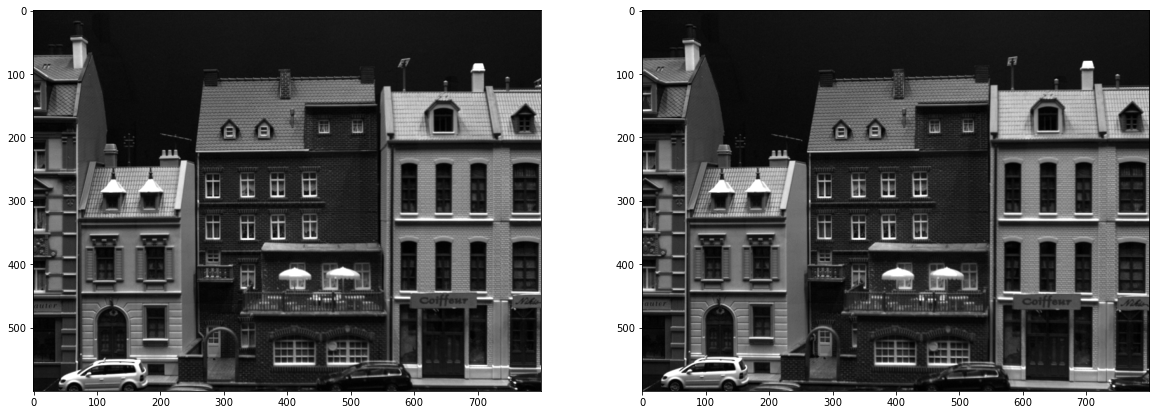

In [229]:
two_image_data = np.load('data/TwoImageData.npy', allow_pickle=True).item()

im1 = two_image_data["im1"]
im2 = two_image_data["im2"]

R1 = two_image_data["R1"]
R2 = two_image_data["R2"]

t1 = two_image_data["t1"]
t2 = two_image_data["t2"]

K1 = two_image_data["K"]
K2 = K1.copy()

fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(im1, 'gray')
ax[1].imshow(im2, 'gray');
print(
    "R1: \n{} \n\nt1: \n{} \n\nR2: \n{} \n\nt2: \n{}".format(
        R1, t1, np.round(R2, 4), np.round(t2, 4)
    )
)

$R_1$ is the identity matrix and $t_1$ is null so we are already in the reference frame of camera 1.

In [76]:
F = fundamental_matrix(K1, K2, R2, t2, R1=R1, t1=t1)
F

array([[ 6.67972386e-12, -7.85049967e-10,  1.17921973e-07],
       [-9.75936980e-10, -4.86806510e-12,  3.28699196e-05],
       [ 4.23506610e-07, -3.21704080e-05, -2.12002228e-04]])

### 9, 10. Draw the epipolar lines

In [161]:
def DrawLine(l, shape, ax):
    """
    Checks where the line intersects the four sides of the image
    and finds the two intersections that are within the frame.
    """
    def in_frame(l_im):
        q = np.cross(l.flatten(), l_im)
        q = q[:2] / q[2]
        if all(q >= 0) and all(q + 1 <= shape[1::-1]):
            return q
    lines = [
        [1, 0, 0           ],
        [0, 1, 0           ],
        [1, 0, 1 - shape[1]],
        [0, 1, 1 - shape[0]]
    ]
    P = [in_frame(l_im) for l_im in lines if in_frame(l_im) is not None]
    ax.plot(*np.array(P).T, 'r-')

    
def click_and_draw(im, im2, F, reverse_axis=False):
    # Turn off the matplotlib inline to use ginput.
    %matplotlib qt  
    n = 1

    plt.imshow(im)
    x = np.array(plt.ginput(n))
    plt.show()

    q1 = np.hstack(
        (x, np.ones((1, n)))
        ).T
    l2 = F @ q1
    
    %matplotlib inline
    
    i, j = 0, 1
    if reverse_axis:
        i, j = j, i

    fig, ax = plt.subplots(1, 2, figsize=(20, 20))
    ax[i].imshow(im1, 'gray')
    ax[j].imshow(im2, 'gray')
    ax[i].plot(x[:, 0], x[:, 1], 'ro')
    DrawLine(l2, im2.shape, ax[j])
    
    plt.plot()

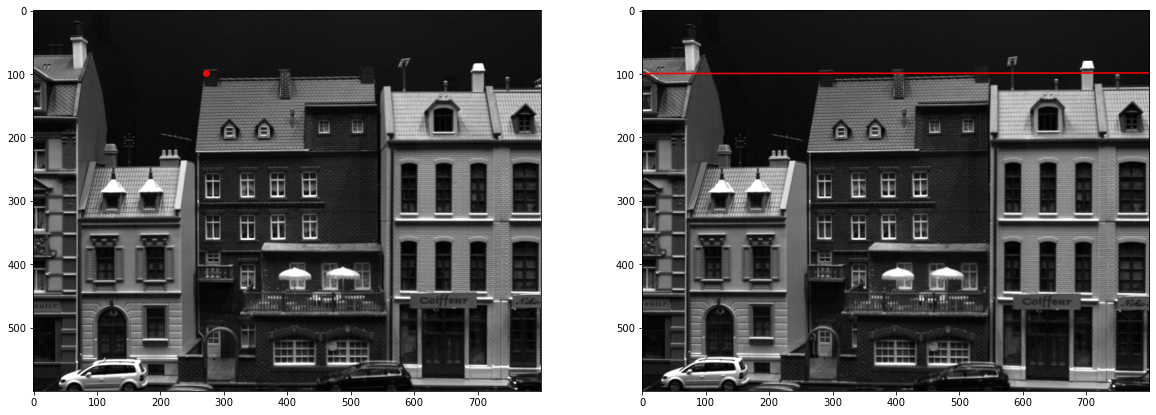

In [177]:
click_and_draw(im1, im2, F)

And the other way around:

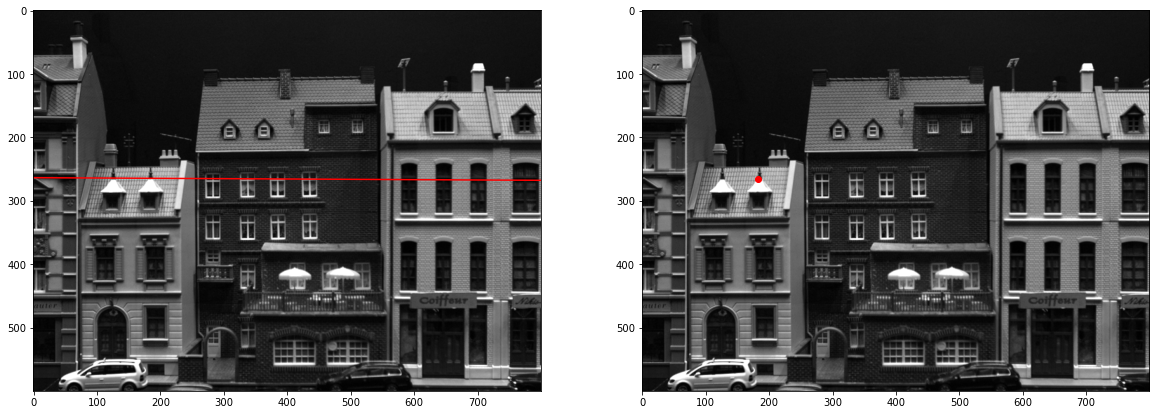

In [178]:
click_and_draw(im2, im1, F.T, reverse_axis=True)

## Triangulation
### 11. Linear triangulation

In [251]:
def triangulate(q, P):
    """
    Return the traingulation.
    
    Parameters
    ----------
    q: 3 x n numpy array
        Pixel coordinates q1... qn
    P: list of 3 x 4 numpy arrays
        Projection matrices P1... Pn
    
    Return
    ------
    Q: 3 x 1 numpy array
        Triangulation of the point using the linear algorithm
    """
    _, n = q.shape

    B = np.zeros((2 * n, 4))
    for i in range(n):
        B[2 * i: 2 * i + 2] = [
            P[i][2, :] * q[0, i] - P[i][0, :],
            P[i][2, :] * q[1, i] - P[i][1, :],
        ]
    u, s, vh = np.linalg.svd(B)
    Q = vh[-1, :]
    return Q[:3].reshape(3, 1) / Q[3]

In [252]:
# Internal parameters of the two cameras
K1 = np.array([
    [1000, 0   , 300],
    [0   , 1000, 200],
    [0   , 0   , 1  ],
])
K2 = K1

# External parameters
R1 = np.eye(3)
t1 = np.zeros((3, 1))

R2 = Rotation.from_euler('xyz', [0.7, -0.5, 0.8]).as_matrix()
t2 = np.array([[0.2, 2, 1]]).T

In [253]:
Q = np.array([4, 6, 2], dtype=float).reshape(3, 1)
P1 = K1 @ np.hstack([R1, t1])
P2 = K2 @ np.hstack([R2, t2])

q1 = projectpoints(K1, R1, t1, Q)
q2 = projectpoints(K2, R2, t2, Q)

triangulate(np.hstack((q1, q2)), [P1, P2])

array([[4.],
       [6.],
       [2.]])